In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import sys
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.fftpack as fp
from scipy import fftpack 
from scipy import signal
from scipy import ndimage
import astropy.convolution

# Functions to obtain the frames and graph

In [2]:
def next_odd(x):
    """
    Find the next odd number.
    
    Parameters
    ----------
    x : int or float
        Number
        
    Returns
    -------    
    x : int
        Next odd number.
    """
    x = np.ceil(x)
    if x % 2 == 1:
        return x
    else:
        x += 1
        return x

In [3]:
def get_frames(dir_video, dir_frames):
    cap= cv2.VideoCapture(dir_video)
    i=0
    os.mkdir(dir_frames)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        cv2.imwrite(dir_frames + 'kang'+str(i)+'.jpg',frame)
        i+=1
    cap.release()
    cv2.destroyAllWindows()
    
#get_frames('data/20khz.mp4', '20khz/')    

In [4]:
def contrast_plot(frame, x_min = -0.5, x_max = 0.5, bar_label = r'Contrast', save = 'off'):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    p =plt.imshow(frame, cmap = 'viridis')
    #cbar = fig.colorbar(p, ax=ax)
    #plt.clim(x_min,x_max)
    #cbar.ax.get_yaxis().labelpad = 20
    #cbar.ax.set_ylabel(bar_label, rotation=-270, fontsize=20)
    #cbar.ax.tick_params(labelsize=18)
    plt.ylabel('y  [pixel]', fontsize = 20)
    plt.xlabel('x  [pixel]', fontsize = 20)
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    
    if save != 'off':
        plt.savefig('images/' + save + '.pdf', dpi = 720)

def get_frame(dir_frame_n,x = 400, x_0=600, y = 750, y_0=600):
    img = image.imread(dir_frame_n)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray[x:x+x_0,y:y+y_0]

## Get frames

In [5]:
frame_25 = get_frame('20khz/kang100.jpg')        

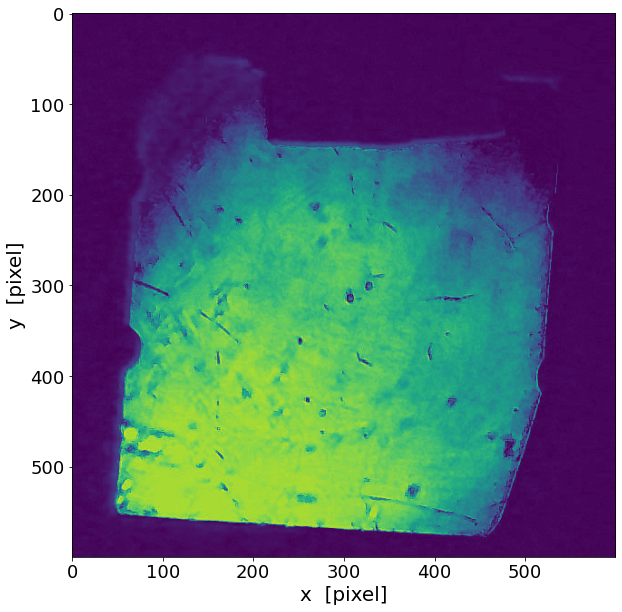

In [374]:
contrast_plot(frame_25, save='20khz')

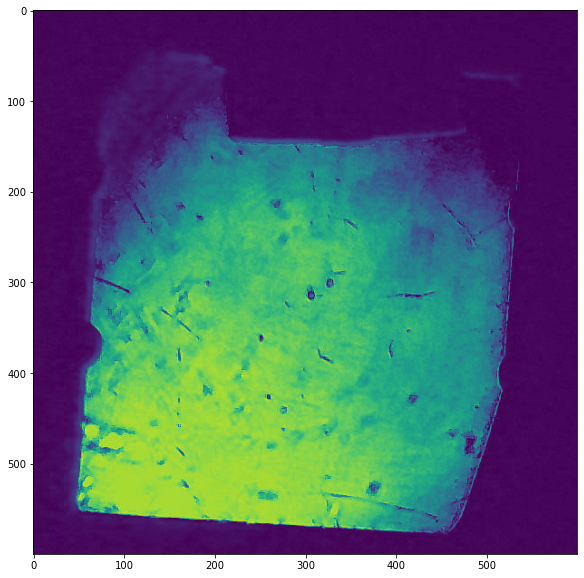

In [353]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(frame_25, cmap ='viridis')

In [6]:
# Fourier transform
frame = frame_25.copy()
frame_fft = np.fft.fft2(frame)

<ipython-input-372-a1f4fc910511>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=plt.cm.gray)


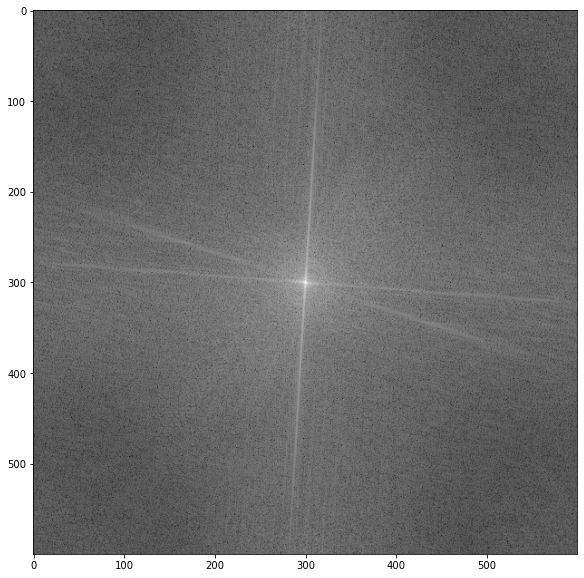

In [372]:
F1 = fftpack.fft2((frame_25).astype(float))
F2 = fftpack.fftshift(F1)
plt.figure(figsize=(10,10))
plt.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=plt.cm.gray)
plt.show()

<ipython-input-375-6f48a890e840>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='20khz_fft')


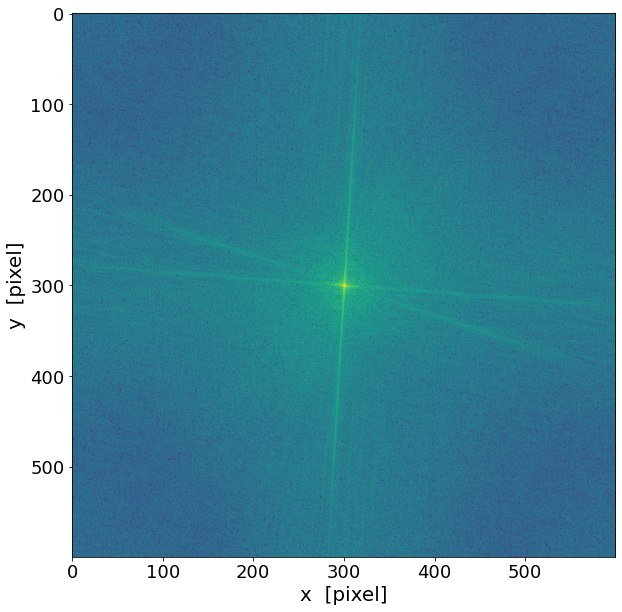

In [375]:
contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='20khz_fft')

## circular filter application for low frequencies

<ipython-input-376-3fbe9d6d8c22>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='20khz_fft_filt_cir')


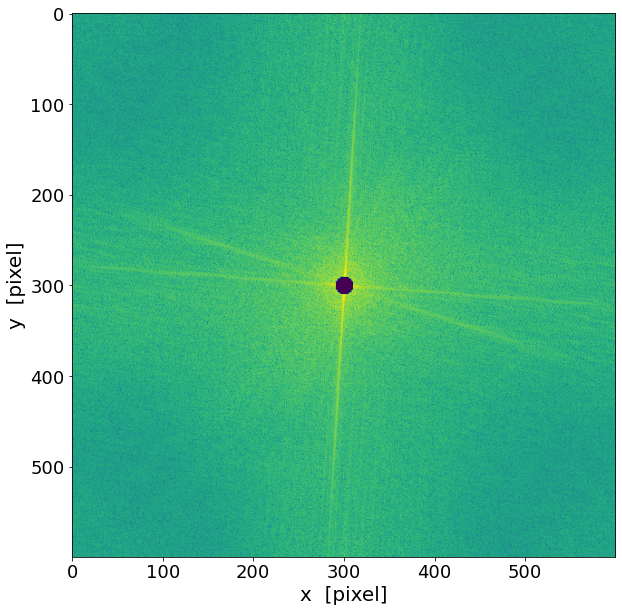

In [376]:
(w, h) = frame_25.shape
half_w, half_h = int(w/2), int(h/2)

F2 = fftpack.fftshift(F1)
# high pass filter
n = 25
for i in range(len(F2)):
    for j in range(len(F2[0])):
        if (i-half_w)**2+(j-half_h)**2 < 100:
                F2[i,j] = 0

#F2[half_w-n:half_w+n+1,half_h-n:half_h+n+1] = 0 # select all but the first 50x50 (low) frequencies
contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='20khz_fft_filt_cir')

### Inverse Fourier Transform

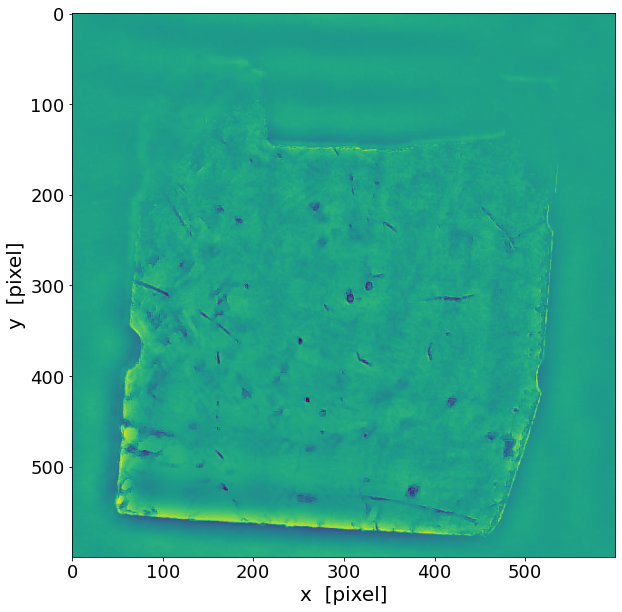

In [377]:
im1 = fp.ifft2(fftpack.ifftshift(F2)).real
contrast_plot(im1, save='20khz_filt_cir')

### The same procedure but using a Gaussian kernel

<ipython-input-12-a1f4fc910511>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=plt.cm.gray)


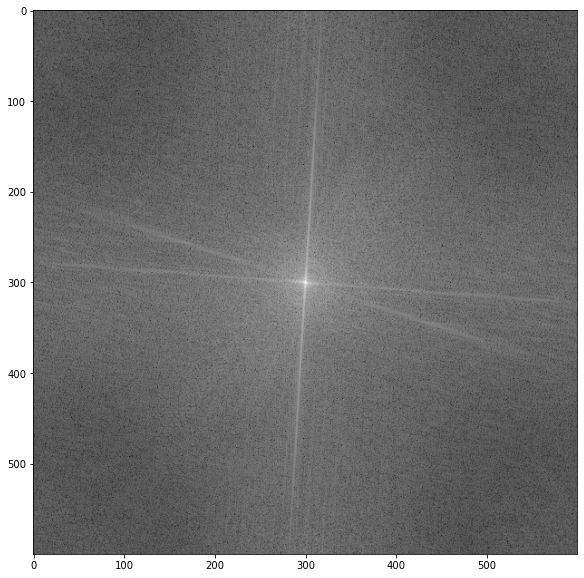

In [12]:
F1 = fftpack.fft2((frame_25).astype(float))
F2 = fftpack.fftshift(F1)
plt.figure(figsize=(10,10))
plt.imshow( (20*np.log10( 0.1 + F2)).astype(int), cmap=plt.cm.gray)
plt.show()

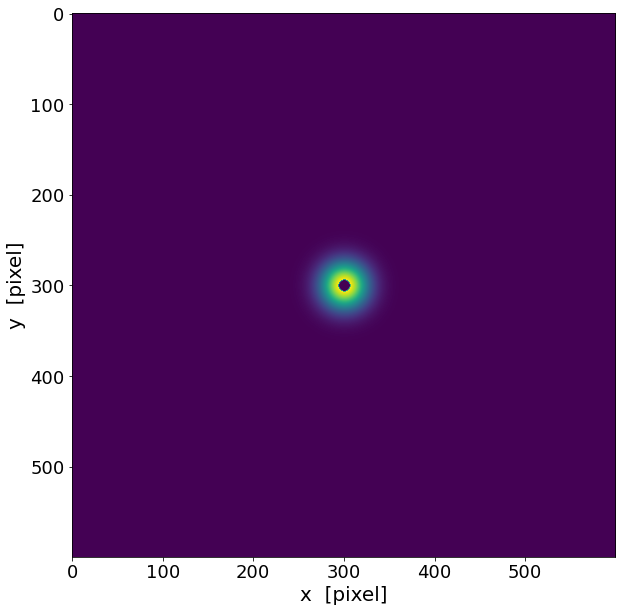

In [13]:
size = 50
sigma = 18
psf = astropy.convolution.Gaussian2DKernel(sigma)
psf = np.array(psf)

(w, h) = psf.shape
half_w, half_h = int(w/2), int(h/2)

n = 25
for i in range(len(psf)):
    for j in range(len(psf[0])):
        if (i-half_w)**2+(j-half_h)**2 < 40:
                psf[i,j] = 0

#mask = psf < np.max(psf)/1.2
#psf[~mask] = 0
psf = psf / psf.sum()

a, b = F2.shape
    
fshape = a
center = fshape - (fshape+1) // 2
new_psf = np.zeros([fshape, fshape])
index = slice(center - psf.shape[0] // 2, center + (psf.shape[0] + 1) // 2)
new_psf[index, index] = psf

contrast_plot(new_psf, save='filt_gaussian_18_circ40')

<ipython-input-15-57fa8d3af072>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_18_circ40')


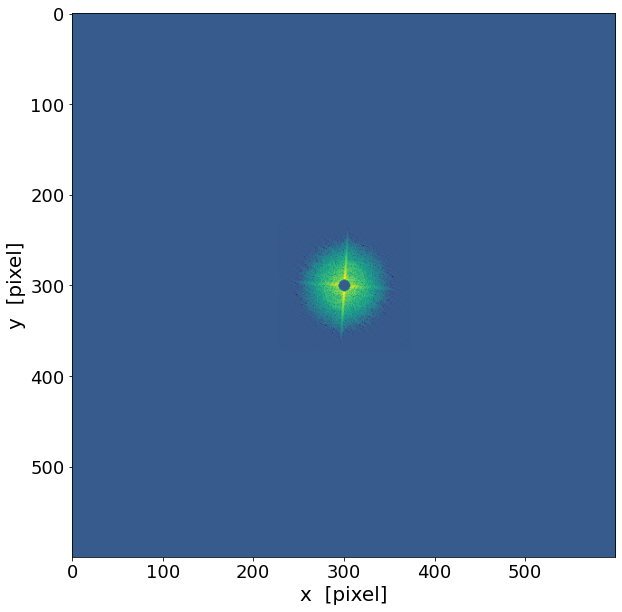

In [15]:
furier_m = new_psf*F2

#plt.imshow( (20*np.log10( 0.1 + furier_m)).astype(int), cmap=plt.cm.gray)
contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_18_circ40')

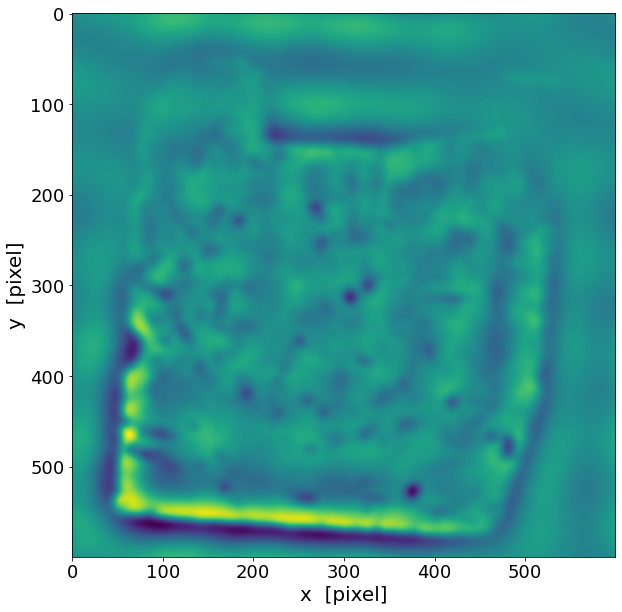

In [495]:
im1 = fp.ifft2(fftpack.ifftshift(furier_m)).real
contrast_plot(im1, save='20khz_filt_gaussian_18_circ40')

### With other Gaussian kernel

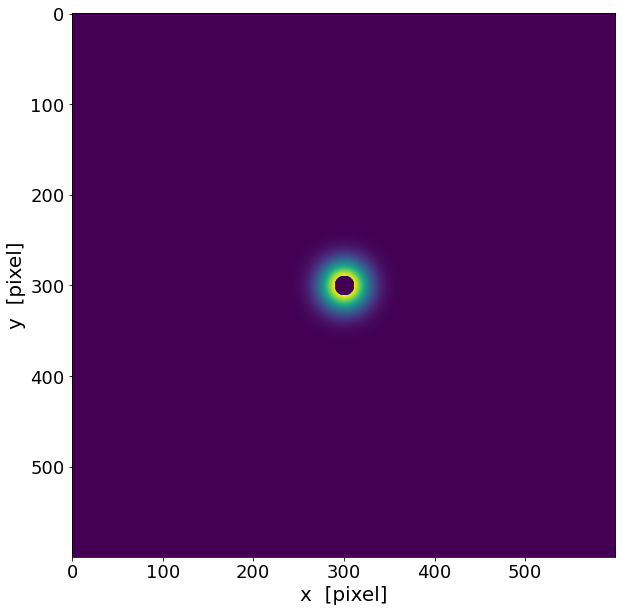

In [496]:
size = 50
sigma = 18
psf = astropy.convolution.Gaussian2DKernel(sigma)
psf = np.array(psf)

(w, h) = psf.shape
half_w, half_h = int(w/2), int(h/2)

n = 25
for i in range(len(F2)):
    for j in range(len(F2[0])):
        if (i-half_w)**2+(j-half_h)**2 < 120:
                psf[i,j] = 0

#mask = psf < np.max(psf)/1.2
#psf[~mask] = 0
psf = psf / psf.sum()

a, b = F2.shape
    
fshape = a
center = fshape - (fshape+1) // 2
new_psf = np.zeros([fshape, fshape])
index = slice(center - psf.shape[0] // 2, center + (psf.shape[0] + 1) // 2)
new_psf[index, index] = psf

contrast_plot(new_psf, save='filt_gaussian_18_circ120')

<ipython-input-497-9f6288ea7d10>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_18_circ120')


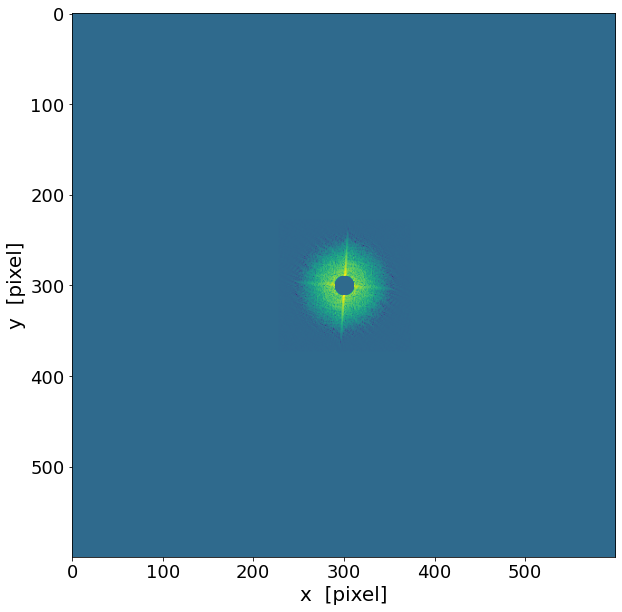

In [497]:
furier_m = new_psf*F2

#plt.imshow( (20*np.log10( 0.1 + furier_m)).astype(int), cmap=plt.cm.gray)
contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_18_circ120')

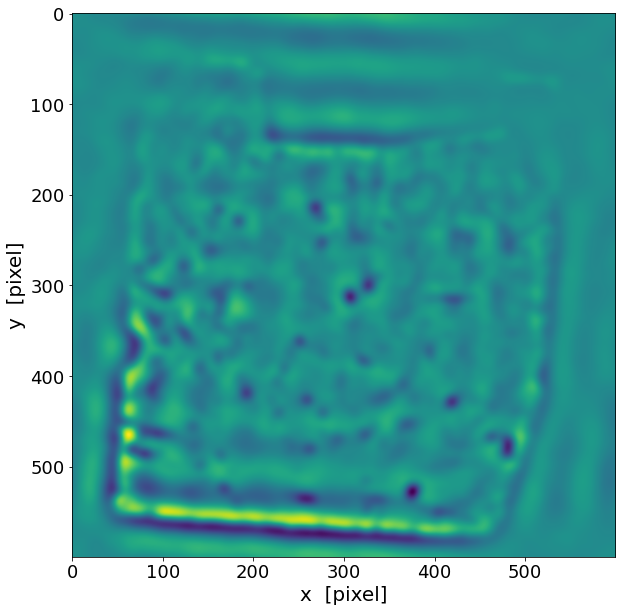

In [498]:
im1 = fp.ifft2(fftpack.ifftshift(furier_m)).real
contrast_plot(im1, save='20khz_filt_gaussian_18_circ120')

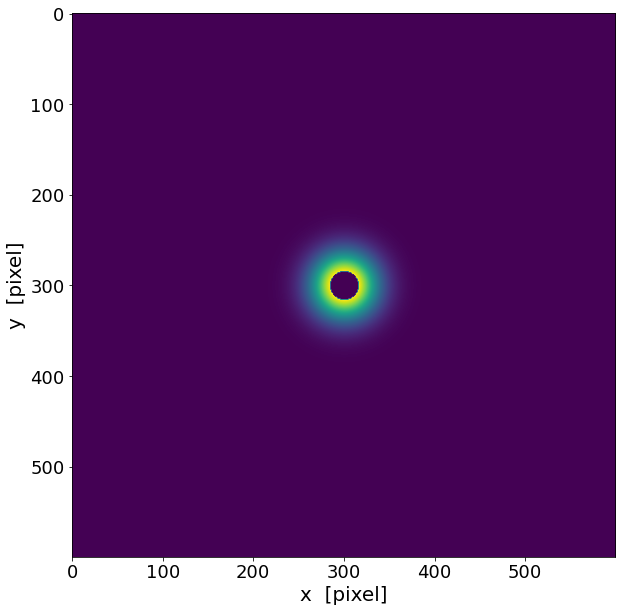

In [515]:
size = 50
sigma = 25
psf = astropy.convolution.Gaussian2DKernel(sigma)
psf = np.array(psf)

(w, h) = psf.shape
half_w, half_h = int(w/2), int(h/2)

n = 25
for i in range(len(F2)):
    for j in range(len(F2[0])):
        if (i-half_w)**2+(j-half_h)**2 < 250:
                psf[i,j] = 0

#mask = psf < np.max(psf)/1.2
#psf[~mask] = 0
psf = psf / psf.sum()

a, b = F2.shape
    
fshape = a
center = fshape - (fshape+1) // 2
new_psf = np.zeros([fshape, fshape])
index = slice(center - psf.shape[0] // 2, center + (psf.shape[0] + 1) // 2)
new_psf[index, index] = psf

contrast_plot(new_psf, save='filt_gaussian_25_circ250')

<ipython-input-516-181ef27c701e>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_25_circ250')


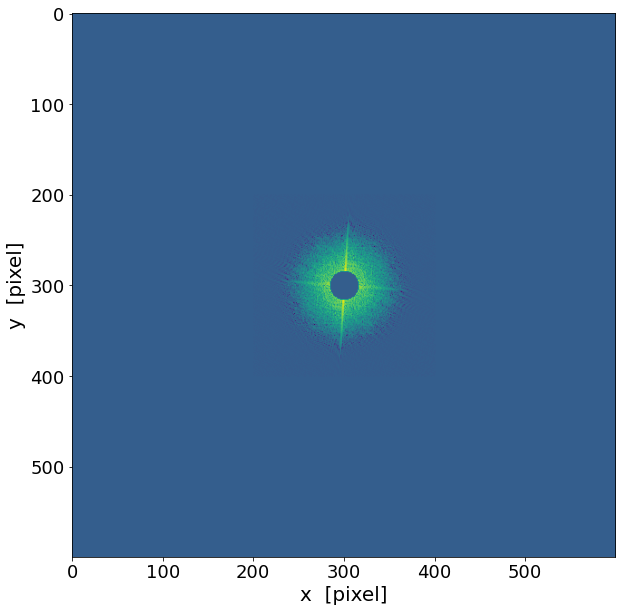

In [516]:
furier_m = new_psf*F2

#plt.imshow( (20*np.log10( 0.1 + furier_m)).astype(int), cmap=plt.cm.gray)
contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='fft_filt_gaussian_25_circ250')

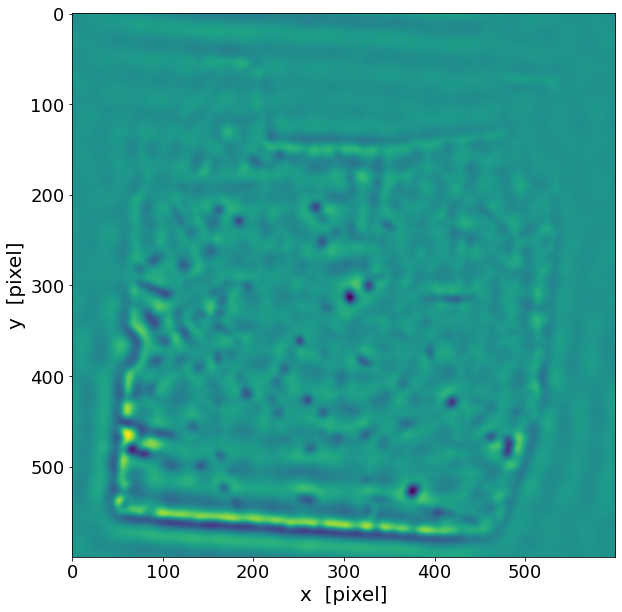

In [517]:
im1 = fp.ifft2(fftpack.ifftshift(furier_m)).real
contrast_plot(im1, save='20khz_filt_gaussian_25_circ250')

# 30 khz

In [540]:
frame_30 = get_frame('30khz/kang100.jpg', x=350, y=650)        

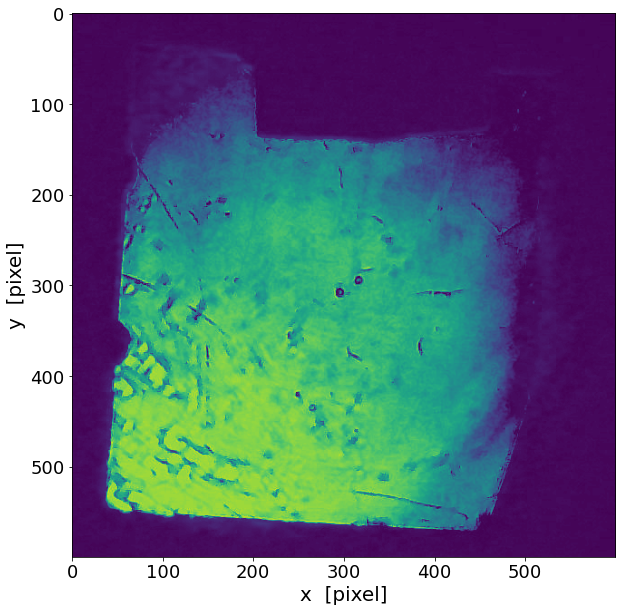

In [542]:
contrast_plot(frame_30, save='30khz')

<ipython-input-543-b1b73fafea8b>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='30khz_fft')


<Figure size 720x720 with 0 Axes>

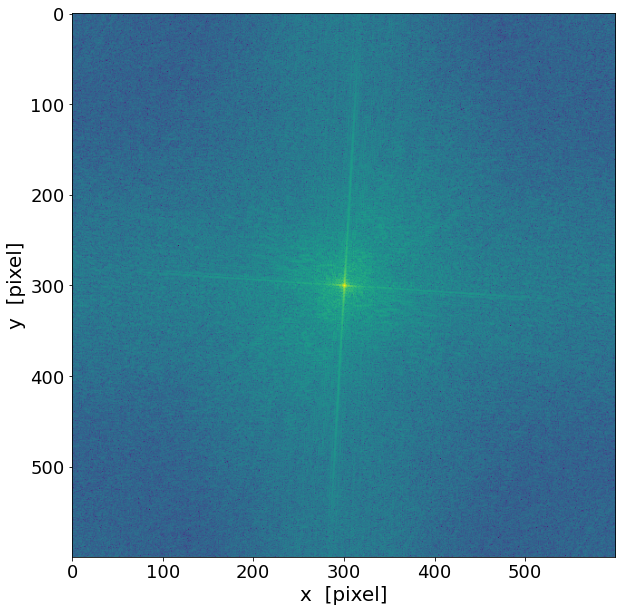

In [543]:
F1 = fftpack.fft2((frame_30).astype(float))
F2 = fftpack.fftshift(F1)
plt.figure(figsize=(10,10))
contrast_plot((20*np.log10( 0.1 + F2)).astype(int), save='30khz_fft')

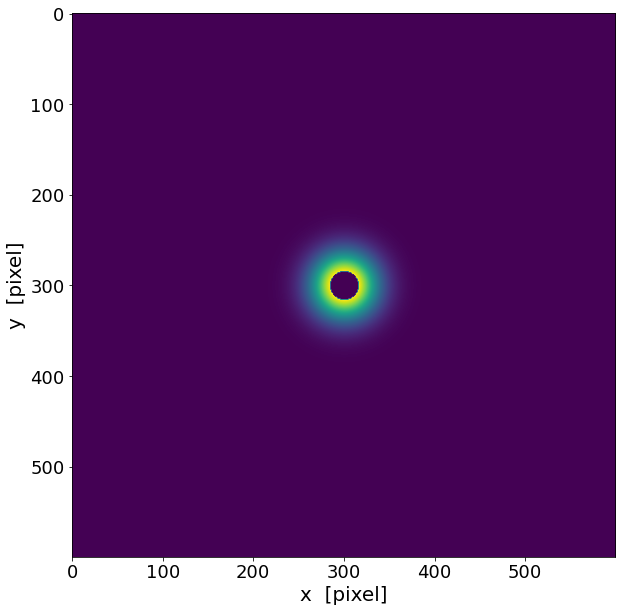

In [515]:
size = 50
sigma = 25
psf = astropy.convolution.Gaussian2DKernel(sigma)
psf = np.array(psf)

(w, h) = psf.shape
half_w, half_h = int(w/2), int(h/2)

n = 25
for i in range(len(F2)):
    for j in range(len(F2[0])):
        if (i-half_w)**2+(j-half_h)**2 < 250:
                psf[i,j] = 0

#mask = psf < np.max(psf)/1.2
#psf[~mask] = 0
psf = psf / psf.sum()

a, b = F2.shape
    
fshape = a
center = fshape - (fshape+1) // 2
new_psf = np.zeros([fshape, fshape])
index = slice(center - psf.shape[0] // 2, center + (psf.shape[0] + 1) // 2)
new_psf[index, index] = psf

contrast_plot(new_psf, save='filt_gaussian_25_circ250')

<ipython-input-544-2e6717e92ca4>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='30_fft_filt_gaussian_25_circ250')


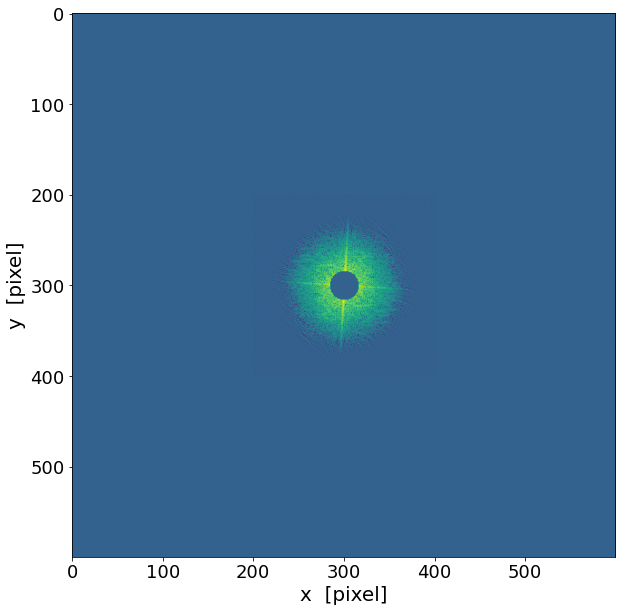

In [544]:
furier_m = new_psf*F2

#plt.imshow( (20*np.log10( 0.1 + furier_m)).astype(int), cmap=plt.cm.gray)
contrast_plot((20*np.log10( 0.1 + furier_m)).astype(int), save='30_fft_filt_gaussian_25_circ250')

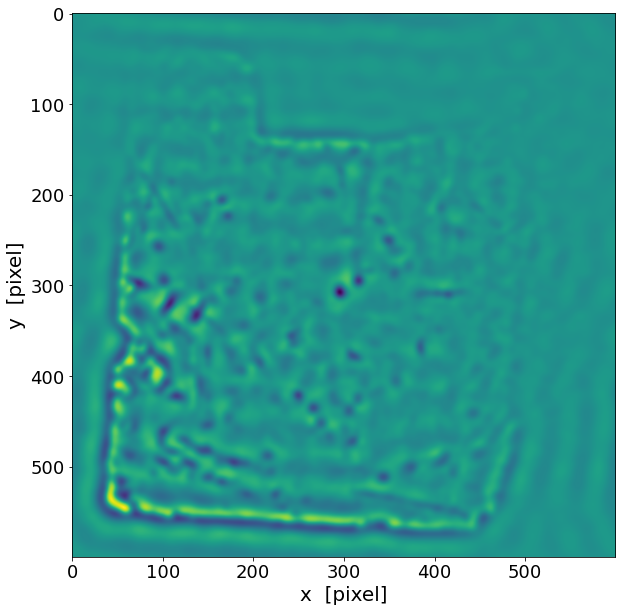

In [545]:
im1 = fp.ifft2(fftpack.ifftshift(furier_m)).real
contrast_plot(im1, save='30khz_filt_gaussian_25_circ250')

In [ ]:
frame_25 = get_frame('20khz/kang100.jpg')        

contrast_plot(frame_25, save='20khz')

In [20]:
mask = np.ones(norm.shape)
mask.shape

(600, 550)

In [21]:
mask[0:50,0:50] = 0
mask[0:50,500:550] = 0

mask[550:600,0:50] = 0
mask[550:600,500:550] = 0

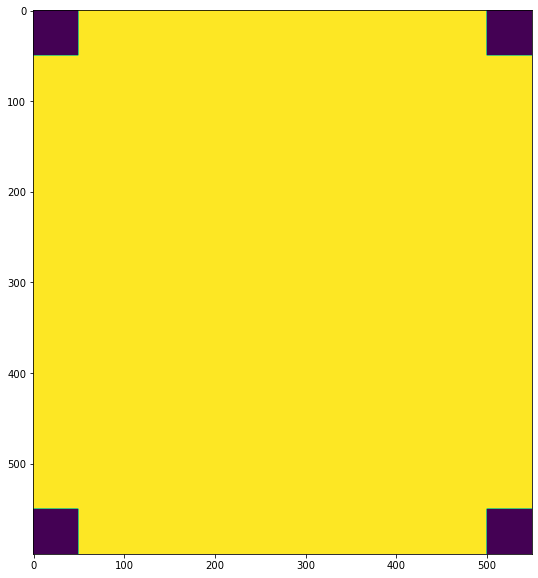

In [22]:
fig = plt.figure(figsize=(12, 10))


plt.imshow(mask)

In [23]:
new_array = mask * frame_fft
#fig = plt.figure(figsize=(12, 10))


#plt.imshow(np.log10(new_array))

In [24]:
inv_array = np.fft.ifft2(new_array)


normi = np.zeros((inv_array.shape))
for i in range(inv_array.shape[0]):
    for j in range(inv_array.shape[1]):
        normi[i][j] = np.linalg.norm(inv_array[i][j])
normi     

array([[0.07338526, 0.09897345, 0.18064449, ..., 0.56337522, 0.39593249,
        0.22035151],
       [0.14361225, 0.23604863, 0.73067364, ..., 0.35344003, 0.18293072,
        0.04615682],
       [0.68718758, 0.625869  , 0.62309801, ..., 0.13299637, 0.0401503 ,
        0.19899894],
       ...,
       [0.66274023, 0.13712111, 0.0850562 , ..., 0.13862841, 0.27654999,
        0.45868203],
       [0.70588215, 0.90020177, 0.07924534, ..., 0.83487205, 0.68161412,
        0.5060399 ],
       [0.80472662, 0.9725015 , 0.11068192, ..., 0.73140476, 0.56922014,
        0.61832861]])

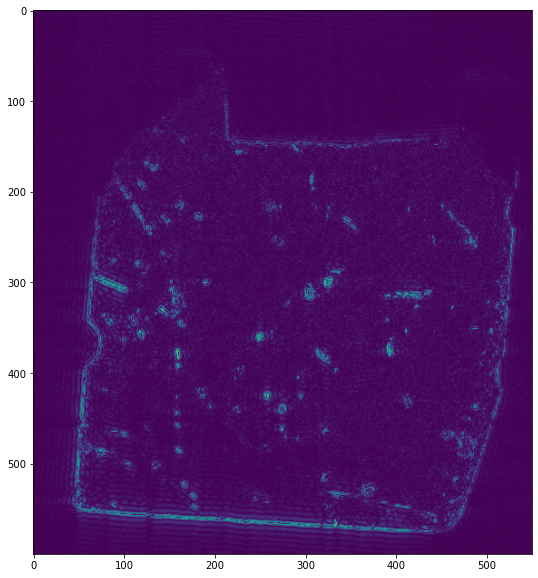

In [25]:
test = np.fft.ifft2(frame_fft)
fig = plt.figure(figsize=(12, 10))


plt.imshow(normi)

In [6]:
frame_20 = get_frame('20khz/kang100.jpg')      
Z1 = 1
Z2 = 200
Z = Z2-Z1
X = frame_20.shape[0]
Y = frame_20.shape[1]
video = np.zeros((Z,X,Y))

for i in range(Z1,Z2):
    video[i-Z1,:,:] = get_frame('20khz/kang'+ str(i) +'.jpg')  

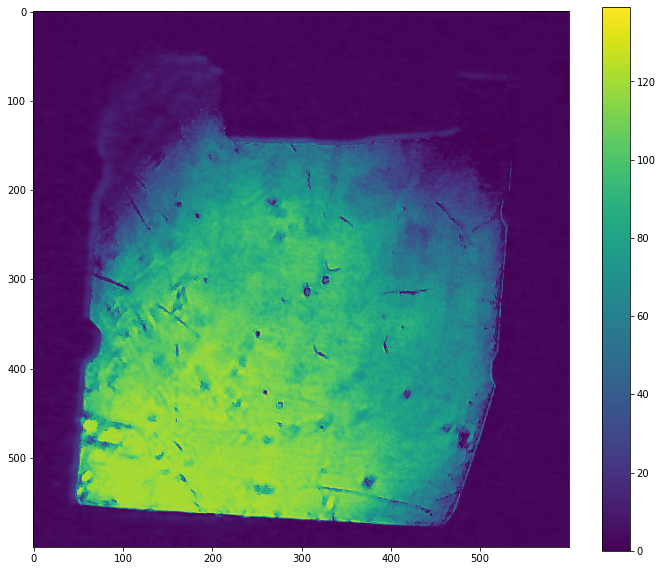

In [7]:
fig = plt.figure(figsize=(12, 10))
plt.imshow(video[10,:,:])
plt.colorbar()

In [8]:
video_fft_0 = np.fft.rfft(video, axis=0)


In [9]:
video_fft = video_fft_0.copy()

<ipython-input-10-c65ab9f4a3d8>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow((20*np.log10( 0.1 + video_fft [10,:,:])).astype(int))


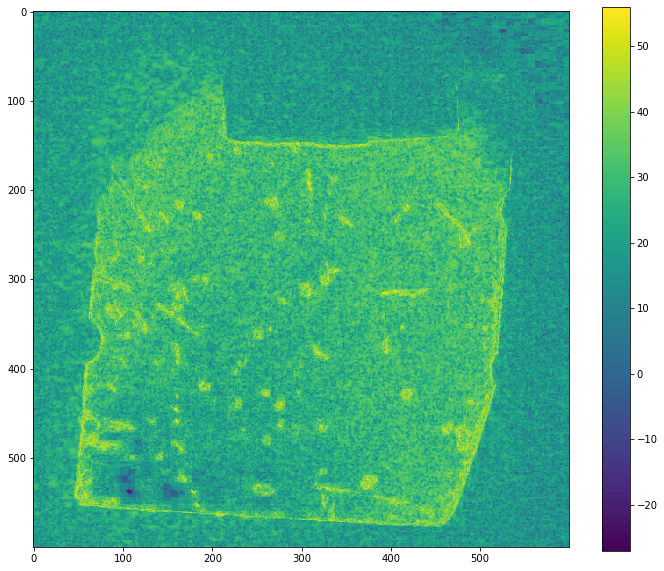

In [10]:
fig = plt.figure(figsize=(12, 10))
plt.imshow((20*np.log10( 0.1 + video_fft [10,:,:])).astype(int))
plt.colorbar()

In [11]:
video_fft[:,150,150].shape

(100,)

In [12]:
video_fft[12,150,150]

(3.5909484476593034+6.74338271763721j)

In [13]:
video_fft = video_fft_0.copy()
video_fft[0:10,:,:]=0

#video_fft[1:91,:,:] = 0

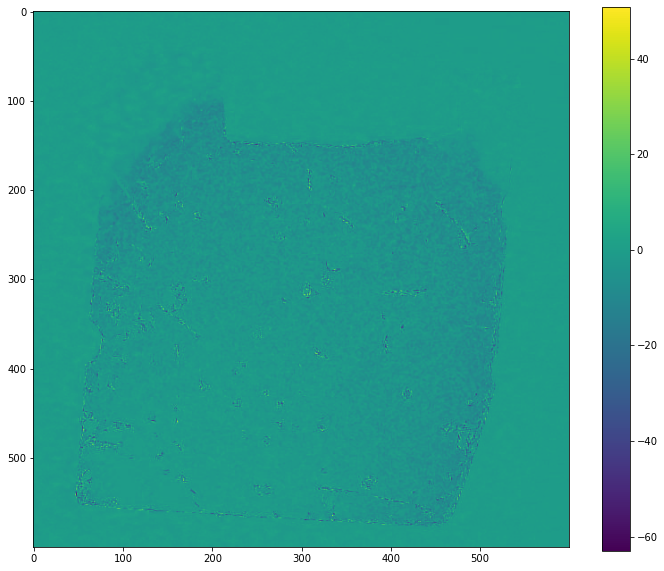

In [14]:
vide_fil = np.fft.irfft(video_fft, axis=0)
fig = plt.figure(figsize=(12, 10))
plt.imshow(vide_fil[10,:,:])
plt.colorbar()

In [15]:
vide_fil.shape

(198, 600, 600)

In [115]:
video_sum_fil = vide_fil.sum(axis=0) 
fig = plt.figure(figsize=(12, 10))
plt.imshow(vide_sum_fil)
plt.colorbar()

NameError: name 'vide_sum_fil' is not defined

<Figure size 864x720 with 0 Axes>

<ipython-input-18-a90ee13c3783>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow((20*np.log10( 0.1 + F2[10,:,:])).astype(int))


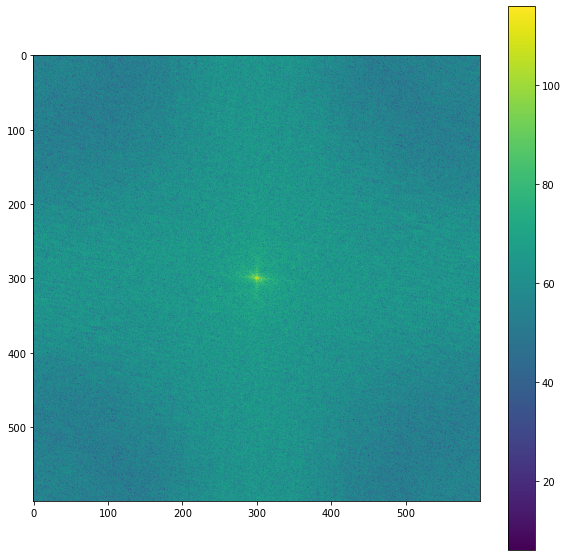

In [18]:
F1 = fftpack.fft2((vide_fil).astype(float))
F2 = fftpack.fftshift(F1)
plt.figure(figsize=(10,10))
plt.imshow((20*np.log10( 0.1 + F2[10,:,:])).astype(int))
plt.colorbar()
#contrast_plot((20*np.log10( 0.1 + F2)).astype(int))#, save='30khz_fft')

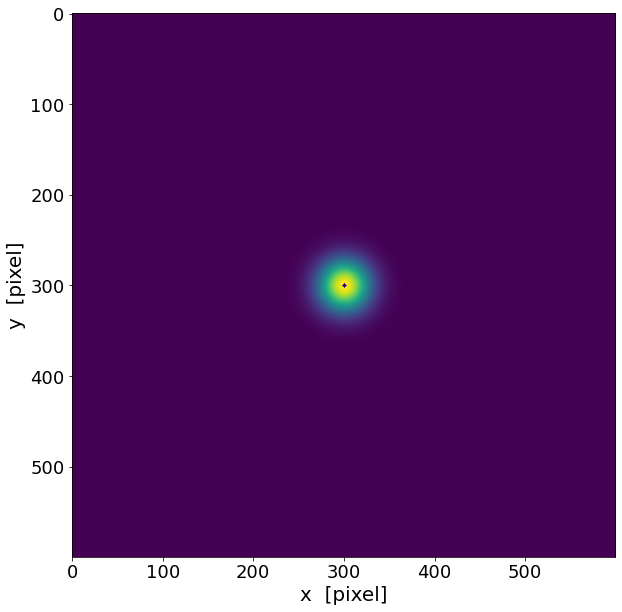

In [20]:
size = 50
sigma = 20
psf = astropy.convolution.Gaussian2DKernel(sigma)
psf = np.array(psf)

(w, h) = psf.shape
half_w, half_h = int(w/2), int(h/2)

n = 25
for i in range(len(F2)):
    for j in range(len(F2[0])):
        if (i-half_w)**2+(j-half_h)**2 < 5:
                psf[i,j] = 0

#mask = psf < np.max(psf)/1.2
#psf[~mask] = 0
psf = psf / psf.sum()

c, a, b = F2.shape
    
fshape = a
center = fshape - (fshape+1) // 2
new_psf = np.zeros([fshape, fshape])
index = slice(center - psf.shape[0] // 2, center + (psf.shape[0] + 1) // 2)
new_psf[index, index] = psf

contrast_plot(new_psf)#, save='filt_gaussian_25_circ250')

In [1]:
furier_m = new_psf*F2

#plt.imshow( (20*np.log10( 0.1 + furier_m)).astype(int), cmap=plt.cm.gray)
contrast_plot((20*np.log10( 0.1 + furier_m[10])).astype(int))#, save='30_fft_filt_gaussian_25_circ250')

NameError: name 'new_psf' is not defined

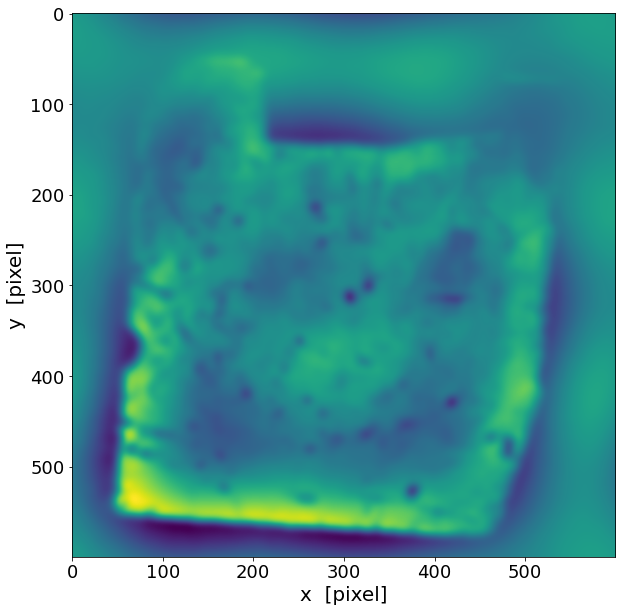

In [64]:
im1 = fp.ifft2(fftpack.ifftshift(furier_m)).real
contrast_plot(im1)#, save='30khz_filt_gaussian_25_circ250')